## Практическая работа №3
Необходимо на основе результатов, полученных при выполнении Практической работы №2, расширить полученный семантический анализатор естественного языка для обработки набора документов (например, на схожесть). Используйте Doc2Vec и/или Word2Vec.

In [18]:
import os
import re
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Загрузка данных

In [ ]:
def load_songs(folder_path="data/text"):
    documents = []
    titles = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                documents.append(content)
                titles.append(filename.replace('.txt', ''))
    
    return documents, titles

songs, song_titles = load_songs("data/song_text")

### Нормализация
Функция *normalize_text* выполняет нормализацию текстов песен, очищая их от лишних символов, пунктуации и стоп слов, а также приводя все слова к нижнему регистру и их базовой форме с помощью лемматизации. За счет этого тексты получаются унифицироваными и готовыми к дальнейшему векторному представлению и семантическому анализу.

In [ ]:
def normalize_text(text):
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = text.lower()
    
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    lemmas = [lemmatizer.lemmatize(w) for w in words if w.isalpha() and w not in stop_words]
    return " ".join(lemmas)

normalized_songs = [normalize_text(song) for song in songs]

### Анализатор тональности

In [ ]:
sia = SentimentIntensityAnalyzer()
labels_dict = {"neu": "нейтральную", "pos": "положительную", "neg": "отрицательную"}

print("Тональность песен:")
for i, song in enumerate(normalized_songs):
    sentiment = max(sia.polarity_scores(song), key=sia.polarity_scores(song).get)
    print(f"Песня '{song_titles[i]}': {labels_dict.get(sentiment, 'сложную')} тональность")

Тональность песен:
Песня '1. Believer': нейтральную тональность
Песня '2. Thunder': нейтральную тональность
Песня '3. Demons': нейтральную тональность
Песня '4. Enemy': нейтральную тональность
Песня '5. Radioactive': нейтральную тональность


### LSA анализ

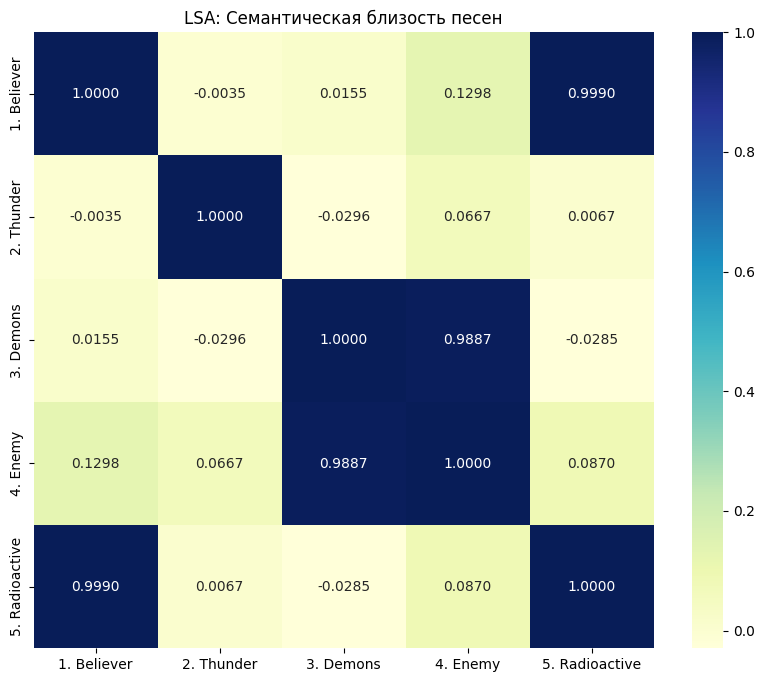

In [33]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(normalized_songs)

lsa = TruncatedSVD(n_components=3, random_state=0)
lsa_vectors = lsa.fit_transform(tfidf_matrix)
lsa_similarity = cosine_similarity(lsa_vectors)

plt.figure(figsize=(10, 8))
sns.heatmap(lsa_similarity, xticklabels=song_titles, yticklabels=song_titles, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("LSA: Семантическая близость песен")
plt.show()

### Анализ тем LSA

In [30]:
feature_names = vectorizer.get_feature_names_out()
print("\nТемы LSA:")
for i, topic in enumerate(lsa.components_):
    idxs = topic.argsort()[-5:][::-1]
    words = [feature_names[idx] for idx in idxs]
    print(f"Тема {i+1}: {', '.join(words)}")


Темы LSA:
Тема 1: oh, believer, npain, ni, ooh
Тема 2: hide, look, demon, enemy, thunder
Тема 3: thunder, nthunder, th, nlightning, thun


### Doc2Vec анализ

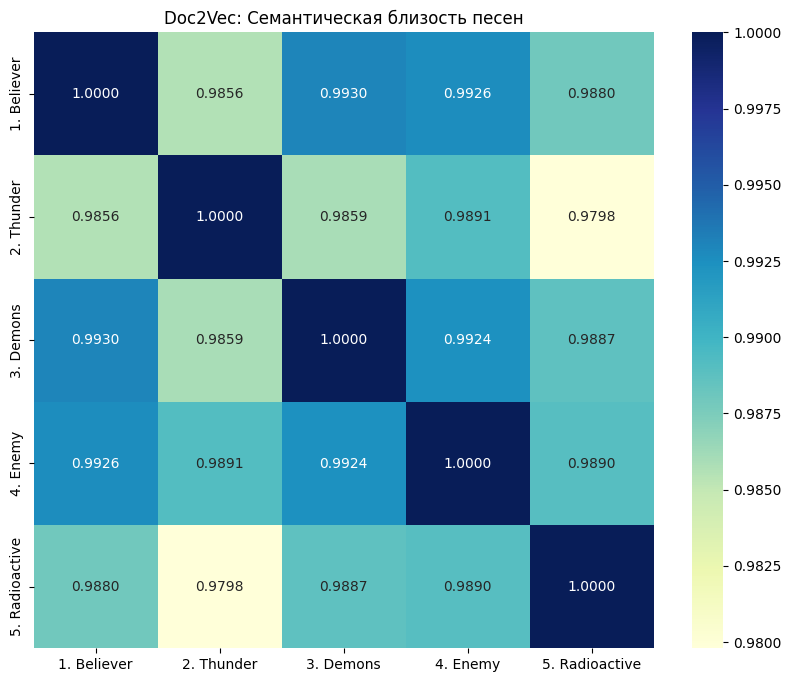

In [34]:
tagged_data = [
    TaggedDocument(words=doc.split(" "), tags=[f"SONG_{i}"])
    for i, doc in enumerate(normalized_songs)
]

doc2vec_model = Doc2Vec(min_count=2, epochs=20, dm=0, workers=4, seed=0)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(
    tagged_data,
    total_examples=doc2vec_model.corpus_count,
    epochs=doc2vec_model.epochs,
)

doc2vec_vectors = np.array([
    doc2vec_model.dv[f"SONG_{i}"] for i in range(len(normalized_songs))
])
doc2vec_similarity = cosine_similarity(doc2vec_vectors)

plt.figure(figsize=(10, 8))
sns.heatmap(doc2vec_similarity, xticklabels=song_titles, yticklabels=song_titles, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Doc2Vec: Семантическая близость песен")
plt.show()

### Word2Vec анализ

In [27]:
sentences = [song.split() for song in normalized_songs]
word2vec_model = Word2Vec(sentences=sentences, min_count=1, vector_size=100, window=5)

print("\nСемантически похожие слова:")
words_for_analysis = list(word2vec_model.wv.key_to_index.keys())[:5]
for word in words_for_analysis:
    if len(word) > 2:
        similar = word2vec_model.wv.most_similar(word, topn=3)
        similar_words = [f"{w[0]}" for w in similar]
        print(f"{word}: {', '.join(similar_words)}")


Семантически похожие слова:
thunder: clappin, dye, nat
nthunder: send, breaking, new
